# Required libs and Pulling in Pre-trained Model

In [2]:
from transformers import BertTokenizer, TFBertForMaskedLM
import tensorflow as tf
import numpy as np
#import re
import matplotlib.pyplot as plt
from datasets import load_dataset
import streamlit as st

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = TFBertForMaskedLM.from_pretrained('bert-base-uncased')

model.summary()

c:\Users\kodom\anaconda3\envs\cis477\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


All PyTorch model weights were used when initializing TFBertForMaskedLM.

All the weights of TFBertForMaskedLM were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForMaskedLM for predictions without further training.


Model: "tf_bert_for_masked_lm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  108891648 
                                                                 
 mlm___cls (TFBertMLMHead)   multiple                  24459834  
                                                                 
Total params: 109514298 (417.76 MB)
Trainable params: 109514298 (417.76 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [3]:
query = "I [MASK] this movie so much"
inp = tokenizer(query,return_tensors='tf')

mask_loc = np.where(inp['input_ids'].numpy()[0] == tokenizer.mask_token_id)[0].tolist()

print(f"Masked Token Position: {mask_loc}")

out = model.predict([inp['input_ids'], inp['attention_mask']])
predicted_tokens = np.argmax(out['logits'][0][mask_loc],axis=1).tolist()

predicted_words = tokenizer.decode(predicted_tokens)
print(f"Predicted Words: {predicted_words}")


Masked Token Position: [2]
1/1 [==============================] - 11s 11s/step
Predicted Words: love


# Loading in dataset from Hugging Face

In [23]:
# load in the dataset
dataset_name = "c4"
task_name = "en"
dataset = load_dataset(dataset_name, task_name, split="validation",streaming=True)


# count = 0
# for example in dataset_list:
#     if count >= 1000:
#         break
#     # Process or use the example as needed
#     print(example["text"])  # Or perform any other operation
#     count += 1

#convert dataset to a list so I can fine tune
dataset_list = list(dataset)

# Taking a portion of the dataset and tokenizing 

In [24]:

# sampleing subset for demonstration purposes
subset_size = 100
data_subset = dataset_list[:min(subset_size, len(dataset_list))]

# extracting texts from the subset
texts = [example["text"] for example in data_subset]

# tokenize the texts
inputs = tokenizer(texts,max_length=100, padding='max_length', truncation=True, return_tensors="tf")

print(inputs.keys())


dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])


In [25]:
inputs['labels'] = inputs['input_ids']
inputs.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'labels'])

# Adding Labels and Fine-tuning the Model

In [26]:
# Adding Labels (helps with fine-tuning)
inp_ids = []
labels = []
max_label_length = 100
for inp in inputs.input_ids.numpy():
    actual_tokens = list(set(range(100)) - set(np.where((inp == 101) | (inp == 102) | (inp == 0))[0].tolist()))
    num_of_token_to_mask = int(len(actual_tokens) * 0.15)
    token_to_mask = np.random.choice(np.array(actual_tokens), size=num_of_token_to_mask, replace=False).tolist()
    
    label = inp[token_to_mask].copy()
    inp[token_to_mask] = 103

    pad_length = max_label_length - len(label)
    label = np.pad(label, (0, pad_length), mode='constant', constant_values=0)

    inp_ids.append(inp)
    labels.append(label)
    
inp_ids = tf.convert_to_tensor(inp_ids)
labels = tf.convert_to_tensor(labels)
inputs['input_ids'] = inp_ids
inputs['labels'] = labels

In [27]:
# Compile and fine-tune the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])
history = model.fit([inputs.input_ids, inputs.attention_mask], inputs.labels, verbose=1, batch_size=14, epochs=6)

Epoch 1/6
8/8 [==============================] - 116s 8s/step - loss: 0.9929 - accuracy: 0.8731
Epoch 2/6
8/8 [==============================] - 41s 5s/step - loss: 0.8491 - accuracy: 0.8780
Epoch 3/6
8/8 [==============================] - 38s 5s/step - loss: 0.7339 - accuracy: 0.8796
Epoch 4/6
8/8 [==============================] - 55s 7s/step - loss: 0.5969 - accuracy: 0.8898
Epoch 5/6
8/8 [==============================] - 62s 8s/step - loss: 0.4439 - accuracy: 0.9066
Epoch 6/6
8/8 [==============================] - 87s 11s/step - loss: 0.2900 - accuracy: 0.9351


# Visual 

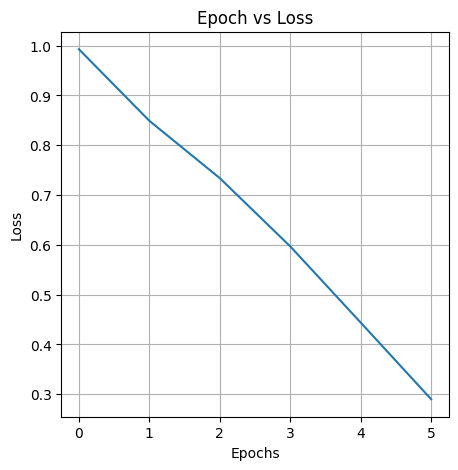

In [28]:
#plotting
losses = history.history['loss']
fig = plt.figure(figsize=(5,5))
ax1 = fig.add_subplot(111)
ax1.plot(range(len(losses)),losses)
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.set_title("Epoch vs Loss")
plt.grid()
plt.show()

# Metrics

In [29]:
train_metrics = model.evaluate([inputs.input_ids, inputs.attention_mask], inputs.labels)

4/4 [==============================] - 30s 2s/step - loss: 0.1246 - accuracy: 0.9753


In [30]:
print(train_metrics)

[0.12461790442466736, 0.9753000140190125]


# Real - time Demo

In [4]:
query = "She fell from the [MASK] bridge"
inp = tokenizer(query,return_tensors='tf')

mask_loc = np.where(inp.input_ids.numpy()[0] == 103)

print(f"Masked Token Position: {mask_loc}")

out = model(inp).logits[0].numpy()
predicted_tokens = np.argmax(out[mask_loc],axis=1).tolist()

predicted_words = tokenizer.decode(predicted_tokens)
print(f"Predicted Words: {predicted_words}")

Masked Token Position: (array([5], dtype=int64),)
Predicted Words: railway
